In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

from core.utils.device import DEVICE
from core.utils.theme import set_theme

set_theme()

model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-1.5B")
model.to(DEVICE)
model.eval()
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B")

In [ ]:
from core.gather_data.hidden_space import collect_hidden_space_by_language
from core.preprocess_data.flores_plus import load_flores_plus
from core.steering.pca import PCASteering

train_df, test_df = load_flores_plus(["eng_Latn", "spa_Latn"], {"eng_Latn": "en", "spa_Latn": "es"}, train_size=200)

hidden_space_by_language_train, token_map_for_language_train = collect_hidden_space_by_language(
    model, tokenizer, train_df, skip_first=True
)

pca_steering = PCASteering().fit(hidden_space_by_language_train)

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Data len:  200


100%|██████████| 200/200 [00:57<00:00,  3.45it/s]
/Users/aigoncharov/dev/plato-meets-llms__ideas-vs-lexical-reflections/src/core/steering/pca.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  self.pca_components = torch.tensor(pca_components)


In [4]:
model.model.layers

ModuleList(
  (0-27): 28 x Qwen2DecoderLayer(
    (self_attn): Qwen2Attention(
      (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
      (k_proj): Linear(in_features=1536, out_features=256, bias=True)
      (v_proj): Linear(in_features=1536, out_features=256, bias=True)
      (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
    )
    (mlp): Qwen2MLP(
      (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
      (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
      (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
    (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
  )
)

In [5]:
from core.integration.SteeredQwen2DecoderLayer import SteeredQwen2DecoderLayer

replacement_layers: list[SteeredQwen2DecoderLayer] = []
for index in [26, 27]:
    replacement_layer = SteeredQwen2DecoderLayer(model.config, index, pca_steering, maintain_direction=False).to(
        model.device
    )
    original_layer = model.model.layers[index]
    replacement_layer.load_state_dict(original_layer.state_dict())
    model.model.layers[index] = replacement_layer
    replacement_layers.append(replacement_layer)

In [6]:
import json

import pandas as pd

# Load the code-switching data
data_path = "../../../data/ted_talks_code_switching_second_half.jsonl"
code_switching_data = []

with open(data_path, "r", encoding="utf-8") as f:
    for line in f:
        code_switching_data.append(json.loads(line))

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(code_switching_data)

# Extract only eng_Latn and spa_Latn columns
df_en_ru = df[["eng_Latn", "spa_Latn"]].copy()

print(f"Loaded {len(df_en_ru)} samples")
print("\nFirst few examples:")
print(df_en_ru.head())

Loaded 2467 samples

First few examples:
                                            eng_Latn  \
0  Good morning. How are you?(Laughter)It's been ...   
1  Thank you so much, Chris. And it's truly a gre...   
2  (Music: "The Sound of Silence," Simon & Garfun...   
3  If you're here today — and I'm very happy that...   
4  About 10 years ago, I took on the task to teac...   

                                            spa_Latn  
0  Good morning. How are you?(Laughter)It's been ...  
1  Thank you so much, Chris. Y es un verdadero ho...  
2  (Music: "The Sound of Silence," Simon & Garfun...  
3  If you're here today — and I'm very happy that...  
4  About 10 years ago, I took on the task to teac...  


In [7]:
import numpy as np
import torch
from torch.nn import functional as F


def get_next_token_logits(model, tokenizer, text):
    """
    Get logits for next token prediction given input text.

    Args:
        model: The language model
        tokenizer: The tokenizer
        text: Input text string

    Returns:
        logits: Tensor of shape (vocab_size,) with logits for next token
    """
    # Tokenize the input
    inputs = tokenizer(text, return_tensors="pt").to(model.device)

    # Get model output
    with torch.no_grad():
        outputs = model(**inputs)

    # Get logits for the last token (next token prediction)
    logits = outputs.logits[0, -1, :]  # Shape: (vocab_size,)

    return logits


def compare_logit_distributions(sample_idx=0, top_k=20, verbose=True, steering_value=-3.0):
    """
    Compare logit distributions for a single sample across three conditions:
    1. eng_Latn text with steering disabled (baseline English)
    2. spa_Latn text with steering disabled (baseline Russian)
    3. spa_Latn text with steering enabled (rus->eng steering)

    Args:
        sample_idx: Index of the sample to analyze
        top_k: Number of top tokens to display
        verbose: Whether to print sample details and predictions
        steering_value: Steering direction value to apply (default: -3.0)

    Returns:
        Dictionary with logits and probabilities for all three conditions
    """
    # Get the text samples
    eng_text = df_en_ru.iloc[sample_idx]["eng_Latn"]
    rus_text = df_en_ru.iloc[sample_idx]["spa_Latn"]

    if verbose:
        print(f"\n{'=' * 80}")
        print(f"Sample {sample_idx}")
        print(f"{'=' * 80}")
        print(f"\nEnglish text: {eng_text}")
        print(f"\nRussian text: {rus_text}")
        print(f"\n{'-' * 80}")

    # Condition 1: eng_Latn with steering disabled
    replacement_layers[0].disable()
    replacement_layers[1].disable()
    logits_eng_no_steer = get_next_token_logits(model, tokenizer, eng_text)
    probs_eng_no_steer = F.softmax(logits_eng_no_steer, dim=-1)

    # Condition 2: spa_Latn with steering disabled (baseline)
    replacement_layers[0].disable()
    replacement_layers[1].disable()
    logits_rus_no_steer = get_next_token_logits(model, tokenizer, rus_text)
    probs_rus_no_steer = F.softmax(logits_rus_no_steer, dim=-1)

    # Condition 3: spa_Latn with steering enabled (rus->eng)
    replacement_layers[1].set_steering_direction(steering_value)
    logits_rus_with_steer = get_next_token_logits(model, tokenizer, rus_text)
    probs_rus_with_steer = F.softmax(logits_rus_with_steer, dim=-1)

    # Disable steering after we're done
    replacement_layers[0].disable()
    replacement_layers[1].disable()

    # Get top-k tokens for each condition
    top_k_eng = torch.topk(probs_eng_no_steer, top_k)
    top_k_rus_no = torch.topk(probs_rus_no_steer, top_k)
    top_k_rus_yes = torch.topk(probs_rus_with_steer, top_k)

    if verbose:
        print(f"\nTop-{top_k} predicted tokens:")
        print("\n1. English text (no steering - baseline):")
        for i, (prob, idx) in enumerate(zip(top_k_eng.values, top_k_eng.indices)):
            token = tokenizer.decode([idx])
            print(f"  {i + 1:2d}. {token:50s} (prob: {prob:.4f})")

        print("\n2. Russian text (no steering - baseline):")
        for i, (prob, idx) in enumerate(zip(top_k_rus_no.values, top_k_rus_no.indices)):
            token = tokenizer.decode([idx])
            print(f"  {i + 1:2d}. {token:50s} (prob: {prob:.4f})")

        print("\n3. Russian text (WITH steering rus->eng):")
        for i, (prob, idx) in enumerate(zip(top_k_rus_yes.values, top_k_rus_yes.indices)):
            token = tokenizer.decode([idx])
            print(f"  {i + 1:2d}. {token:50s} (prob: {prob:.4f})")

    return {
        "eng_text": eng_text,
        "rus_text": rus_text,
        "logits_eng_no_steer": logits_eng_no_steer,
        "logits_rus_no_steer": logits_rus_no_steer,
        "logits_rus_with_steer": logits_rus_with_steer,
        "probs_eng_no_steer": probs_eng_no_steer,
        "probs_rus_no_steer": probs_rus_no_steer,
        "probs_rus_with_steer": probs_rus_with_steer,
    }


# Test with first sample
results = compare_logit_distributions(sample_idx=0, top_k=20)



Sample 0

English text: Good morning. How are you?(Laughter)It's been great, hasn't it? I've been blown away by the whole thing. In fact, I'm

Russian text: Good morning. How are you?(Laughter)It's been great, hasn't it? Me ha sorprendido todo el asunto. De hecho, estoy

--------------------------------------------------------------------------------

Top-20 predicted tokens:

1. English text (no steering - baseline):
   1.  still                                             (prob: 0.0768)
   2.  going                                             (prob: 0.0687)
   3.  not                                               (prob: 0.0664)
   4.  so                                                (prob: 0.0647)
   5.  a                                                 (prob: 0.0601)
   6.  just                                              (prob: 0.0391)
   7.  really                                            (prob: 0.0269)
   8.  in                                                (prob: 0.0243)
 

In [8]:
def compute_distribution_metrics(results, verbose=True):
    """
    Compute numerical metrics comparing the three distributions.

    Args:
        results: Dictionary returned by compare_logit_distributions
        verbose: Whether to print the metrics

    Returns:
        Dictionary with various comparison metrics
    """
    # Extract probabilities
    p_eng = results["probs_eng_no_steer"]
    p_rus_no = results["probs_rus_no_steer"]
    p_rus_yes = results["probs_rus_with_steer"]

    # KL divergence: D_KL(P || Q) = sum(P * log(P / Q))
    # We add small epsilon to avoid log(0)
    eps = 1e-10

    kl_rus_no_to_eng = torch.sum(p_eng * torch.log((p_eng + eps) / (p_rus_no + eps))).item()
    kl_rus_yes_to_eng = torch.sum(p_eng * torch.log((p_eng + eps) / (p_rus_yes + eps))).item()
    kl_rus_yes_to_rus_no = torch.sum(p_rus_no * torch.log((p_rus_no + eps) / (p_rus_yes + eps))).item()

    # Jensen-Shannon divergence (symmetric version of KL)
    def js_divergence(p, q):
        m = 0.5 * (p + q)
        return (
            0.5 * torch.sum(p * torch.log((p + eps) / (m + eps))).item()
            + 0.5 * torch.sum(q * torch.log((q + eps) / (m + eps))).item()
        )

    js_eng_vs_rus_no = js_divergence(p_eng, p_rus_no)
    js_eng_vs_rus_yes = js_divergence(p_eng, p_rus_yes)
    js_rus_no_vs_rus_yes = js_divergence(p_rus_no, p_rus_yes)

    # Cosine similarity between probability distributions
    def cosine_sim(p, q):
        return torch.dot(p, q) / (torch.norm(p) * torch.norm(q))

    cos_eng_rus_no = cosine_sim(p_eng, p_rus_no).item()
    cos_eng_rus_yes = cosine_sim(p_eng, p_rus_yes).item()
    cos_rus_no_rus_yes = cosine_sim(p_rus_no, p_rus_yes).item()

    # Top-k token overlap
    def top_k_overlap(p1, p2, k=50):
        top_k_1 = set(torch.topk(p1, k).indices.cpu().numpy())
        top_k_2 = set(torch.topk(p2, k).indices.cpu().numpy())
        return len(top_k_1 & top_k_2) / k

    overlap_eng_rus_no = top_k_overlap(p_eng, p_rus_no)
    overlap_eng_rus_yes = top_k_overlap(p_eng, p_rus_yes)
    overlap_rus_no_rus_yes = top_k_overlap(p_rus_no, p_rus_yes)

    metrics = {
        "kl_divergence": {
            "rus_no -> eng": kl_rus_no_to_eng,
            "rus_yes -> eng": kl_rus_yes_to_eng,
            "rus_yes -> rus_no": kl_rus_yes_to_rus_no,
        },
        "js_divergence": {
            "eng vs rus_no": js_eng_vs_rus_no,
            "eng vs rus_yes": js_eng_vs_rus_yes,
            "rus_no vs rus_yes": js_rus_no_vs_rus_yes,
        },
        "cosine_similarity": {
            "eng vs rus_no": cos_eng_rus_no,
            "eng vs rus_yes": cos_eng_rus_yes,
            "rus_no vs rus_yes": cos_rus_no_rus_yes,
        },
        "top50_overlap": {
            "eng vs rus_no": overlap_eng_rus_no,
            "eng vs rus_yes": overlap_eng_rus_yes,
            "rus_no vs rus_yes": overlap_rus_no_rus_yes,
        },
    }

    if verbose:
        print("\n" + "=" * 80)
        print("NUMERICAL COMPARISON METRICS")
        print("=" * 80)

        print("\nKL Divergence (lower = more similar):")
        print(f"  Rus (no steer) → Eng:        {metrics['kl_divergence']['rus_no -> eng']:.4f}")
        print(f"  Rus (WITH steer) → Eng:      {metrics['kl_divergence']['rus_yes -> eng']:.4f}")

        print("\nJensen-Shannon Divergence (lower = more similar, symmetric):")
        print(f"  Eng vs Rus (no steer):       {metrics['js_divergence']['eng vs rus_no']:.4f}")
        print(f"  Eng vs Rus (WITH steer):     {metrics['js_divergence']['eng vs rus_yes']:.4f}")

        print("\nCosine Similarity (higher = more similar, range [-1, 1]):")
        print(f"  Eng vs Rus (no steer):       {metrics['cosine_similarity']['eng vs rus_no']:.4f}")
        print(f"  Eng vs Rus (WITH steer):     {metrics['cosine_similarity']['eng vs rus_yes']:.4f}")

        print("\nTop-50 Token Overlap (higher = more similar, range [0, 1]):")
        print(f"  Eng vs Rus (no steer):       {metrics['top50_overlap']['eng vs rus_no']:.2%}")
        print(f"  Eng vs Rus (WITH steer):     {metrics['top50_overlap']['eng vs rus_yes']:.2%}")

    return metrics


# Compute metrics for the previous results
metrics = compute_distribution_metrics(results)


NUMERICAL COMPARISON METRICS

KL Divergence (lower = more similar):
  Rus (no steer) → Eng:        7.5903
  Rus (WITH steer) → Eng:      3.9608

Jensen-Shannon Divergence (lower = more similar, symmetric):
  Eng vs Rus (no steer):       0.6356
  Eng vs Rus (WITH steer):     0.4554

Cosine Similarity (higher = more similar, range [-1, 1]):
  Eng vs Rus (no steer):       0.0548
  Eng vs Rus (WITH steer):     0.1861

Top-50 Token Overlap (higher = more similar, range [0, 1]):
  Eng vs Rus (no steer):       2.00%
  Eng vs Rus (WITH steer):     28.00%


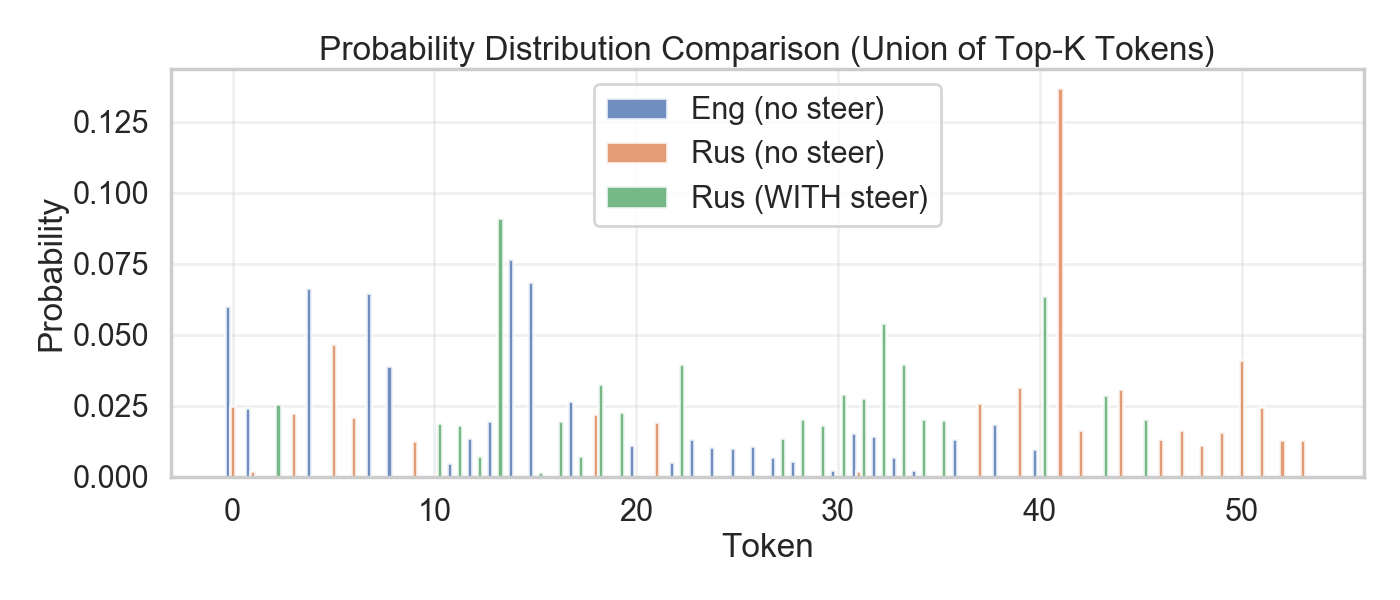

In [9]:
import matplotlib.pyplot as plt


def visualize_logit_distributions(results, top_k=20):
    """
    Create visualizations comparing the three logit distributions.

    Args:
        results: Dictionary returned by compare_logit_distributions
        top_k: Number of top tokens to visualize
    """
    # Extract probabilities
    p_eng = results["probs_eng_no_steer"]
    p_rus_no = results["probs_rus_no_steer"]
    p_rus_yes = results["probs_rus_with_steer"]

    # Get top-k indices from each distribution
    top_k_eng_indices = torch.topk(p_eng, top_k).indices
    top_k_rus_no_indices = torch.topk(p_rus_no, top_k).indices
    top_k_rus_yes_indices = torch.topk(p_rus_yes, top_k).indices

    # Combine all unique indices
    all_indices = torch.unique(torch.cat([top_k_eng_indices, top_k_rus_no_indices, top_k_rus_yes_indices]))

    # Get probabilities for these indices
    p_eng_subset = p_eng[all_indices].cpu().numpy()
    p_rus_no_subset = p_rus_no[all_indices].cpu().numpy()
    p_rus_yes_subset = p_rus_yes[all_indices].cpu().numpy()

    # Get token strings
    tokens = [tokenizer.decode([idx]) for idx in all_indices]

    # Create figure with single plot
    fig = plt.figure(figsize=(14, 6))

    # Bar chart comparing probabilities for top tokens
    x = np.arange(len(tokens))
    width = 0.25

    plt.bar(x - width, p_eng_subset, width, label="Eng (no steer)", alpha=0.8)
    plt.bar(x, p_rus_no_subset, width, label="Rus (no steer)", alpha=0.8)
    plt.bar(x + width, p_rus_yes_subset, width, label="Rus (WITH steer)", alpha=0.8)

    plt.xlabel("Token")
    plt.ylabel("Probability")
    plt.title("Probability Distribution Comparison (Union of Top-K Tokens)")
    # plt.xticks(x, tokens, rotation=45, ha="right")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig


# Create visualizations
fig = visualize_logit_distributions(results, top_k=20)

In [10]:
from tqdm import tqdm


def run_experiment_on_dataset(max_samples=None, steering_value=-3.0):
    """
    Run the logit comparison experiment on the entire dataset.

    Args:
        max_samples: Maximum number of samples to process (None for all)
        steering_value: Steering direction value to apply (default: -3.0)

    Returns:
        DataFrame with aggregated results
    """
    all_metrics = []

    num_samples = len(df_en_ru) if max_samples is None else min(max_samples, len(df_en_ru))

    print(f"Running experiment on {num_samples} samples...")

    for idx in tqdm(range(num_samples)):
        # Get results for this sample (suppress output)
        results = compare_logit_distributions(sample_idx=idx, top_k=500, verbose=False, steering_value=steering_value)

        # Compute metrics (suppress output)
        sample_metrics = compute_distribution_metrics(results, verbose=False)

        # Add sample index
        sample_metrics["sample_idx"] = idx

        # Flatten the nested dictionary
        flattened = {
            "sample_idx": idx,
            "kl_rus_no_to_eng": sample_metrics["kl_divergence"]["rus_no -> eng"],
            "kl_rus_yes_to_eng": sample_metrics["kl_divergence"]["rus_yes -> eng"],
            "kl_rus_yes_to_rus_no": sample_metrics["kl_divergence"]["rus_yes -> rus_no"],
            "js_eng_vs_rus_no": sample_metrics["js_divergence"]["eng vs rus_no"],
            "js_eng_vs_rus_yes": sample_metrics["js_divergence"]["eng vs rus_yes"],
            "js_rus_no_vs_rus_yes": sample_metrics["js_divergence"]["rus_no vs rus_yes"],
            "cos_eng_vs_rus_no": sample_metrics["cosine_similarity"]["eng vs rus_no"],
            "cos_eng_vs_rus_yes": sample_metrics["cosine_similarity"]["eng vs rus_yes"],
            "cos_rus_no_vs_rus_yes": sample_metrics["cosine_similarity"]["rus_no vs rus_yes"],
            "overlap_eng_vs_rus_no": sample_metrics["top50_overlap"]["eng vs rus_no"],
            "overlap_eng_vs_rus_yes": sample_metrics["top50_overlap"]["eng vs rus_yes"],
            "overlap_rus_no_vs_rus_yes": sample_metrics["top50_overlap"]["rus_no vs rus_yes"],
        }

        all_metrics.append(flattened)

    # Convert to DataFrame
    results_df = pd.DataFrame(all_metrics)

    return results_df


In [11]:
def grid_search_steering_direction(steering_values, num_samples=100):
    """
    Perform grid search over steering direction values.

    Args:
        steering_values: List of steering direction values to test
        num_samples: Number of samples to test for each steering value

    Returns:
        DataFrame with results for each steering value
    """
    all_results = []

    print(f"Grid search over {len(steering_values)} steering values, {num_samples} samples each...")

    for steering_val in tqdm(steering_values, desc="Steering values"):
        sample_metrics = []

        for idx in range(min(num_samples, len(df_en_ru))):
            # Get results for this sample using the parameterized function
            results = compare_logit_distributions(sample_idx=idx, top_k=500, verbose=False, steering_value=steering_val)

            # Compute metrics
            metrics = compute_distribution_metrics(results, verbose=False)

            sample_metrics.append(
                {
                    "kl_divergence": metrics["kl_divergence"]["rus_yes -> eng"],
                    "js_divergence": metrics["js_divergence"]["eng vs rus_yes"],
                    "cosine_similarity": metrics["cosine_similarity"]["eng vs rus_yes"],
                    "top50_overlap": metrics["top50_overlap"]["eng vs rus_yes"],
                }
            )

        # Aggregate metrics across samples
        avg_kl = np.mean([m["kl_divergence"] for m in sample_metrics])
        avg_js = np.mean([m["js_divergence"] for m in sample_metrics])
        avg_cos = np.mean([m["cosine_similarity"] for m in sample_metrics])
        avg_overlap = np.mean([m["top50_overlap"] for m in sample_metrics])

        std_kl = np.std([m["kl_divergence"] for m in sample_metrics])
        std_js = np.std([m["js_divergence"] for m in sample_metrics])
        std_cos = np.std([m["cosine_similarity"] for m in sample_metrics])
        std_overlap = np.std([m["top50_overlap"] for m in sample_metrics])

        all_results.append(
            {
                "steering_value": steering_val,
                "avg_kl_divergence": avg_kl,
                "avg_js_divergence": avg_js,
                "avg_cosine_similarity": avg_cos,
                "avg_top50_overlap": avg_overlap,
                "std_kl_divergence": std_kl,
                "std_js_divergence": std_js,
                "std_cosine_similarity": std_cos,
                "std_top50_overlap": std_overlap,
            }
        )

    return pd.DataFrame(all_results)


# Define steering values to test
steering_values = np.arange(-1.0, -5.1, -0.1)

# Run grid search
grid_results = grid_search_steering_direction(steering_values, num_samples=100)


Grid search over 41 steering values, 100 samples each...


Steering values: 100%|██████████| 41/41 [43:50<00:00, 64.15s/it] 


In [12]:
# Display grid search results
print("\n" + "=" * 80)
print("GRID SEARCH RESULTS")
print("=" * 80)
print(grid_results.to_string(index=False))

# Find optimal values for each metric
print("\n" + "=" * 80)
print("OPTIMAL STEERING VALUES")
print("=" * 80)

# For KL and JS: lower is better
best_kl_idx = grid_results["avg_kl_divergence"].idxmin()
print("\nBest for KL Divergence:")
print(f"  Steering value: {grid_results.loc[best_kl_idx, 'steering_value']:.2f}")
print(
    f"  KL Divergence:  {grid_results.loc[best_kl_idx, 'avg_kl_divergence']:.4f} ± {grid_results.loc[best_kl_idx, 'std_kl_divergence']:.4f}"
)

best_js_idx = grid_results["avg_js_divergence"].idxmin()
print("\nBest for JS Divergence:")
print(f"  Steering value: {grid_results.loc[best_js_idx, 'steering_value']:.2f}")
print(
    f"  JS Divergence:  {grid_results.loc[best_js_idx, 'avg_js_divergence']:.4f} ± {grid_results.loc[best_js_idx, 'std_js_divergence']:.4f}"
)

# For cosine similarity and overlap: higher is better
best_cos_idx = grid_results["avg_cosine_similarity"].idxmax()
print("\nBest for Cosine Similarity:")
print(f"  Steering value:      {grid_results.loc[best_cos_idx, 'steering_value']:.2f}")
print(
    f"  Cosine Similarity:   {grid_results.loc[best_cos_idx, 'avg_cosine_similarity']:.4f} ± {grid_results.loc[best_cos_idx, 'std_cosine_similarity']:.4f}"
)

best_overlap_idx = grid_results["avg_top50_overlap"].idxmax()
print("\nBest for Top-50 Overlap:")
print(f"  Steering value:  {grid_results.loc[best_overlap_idx, 'steering_value']:.2f}")
print(
    f"  Top-50 Overlap:  {grid_results.loc[best_overlap_idx, 'avg_top50_overlap']:.2%} ± {grid_results.loc[best_overlap_idx, 'std_top50_overlap']:.2%}"
)


GRID SEARCH RESULTS
 steering_value  avg_kl_divergence  avg_js_divergence  avg_cosine_similarity  avg_top50_overlap  std_kl_divergence  std_js_divergence  std_cosine_similarity  std_top50_overlap
           -1.0           5.764501           0.567899               0.116944             0.1320           2.568009           0.120172               0.203852           0.132424
           -1.1           5.743536           0.569040               0.113506             0.1316           2.532234           0.115069               0.195946           0.125895
           -1.2           5.729519           0.569764               0.111136             0.1308           2.508103           0.111173               0.189638           0.121800
           -1.3           5.722378           0.570045               0.109990             0.1306           2.496960           0.108577               0.185031           0.114628
           -1.4           5.722040           0.569912               0.110076             0.1324    

/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_41793/1016147364.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_41793/1016147364.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


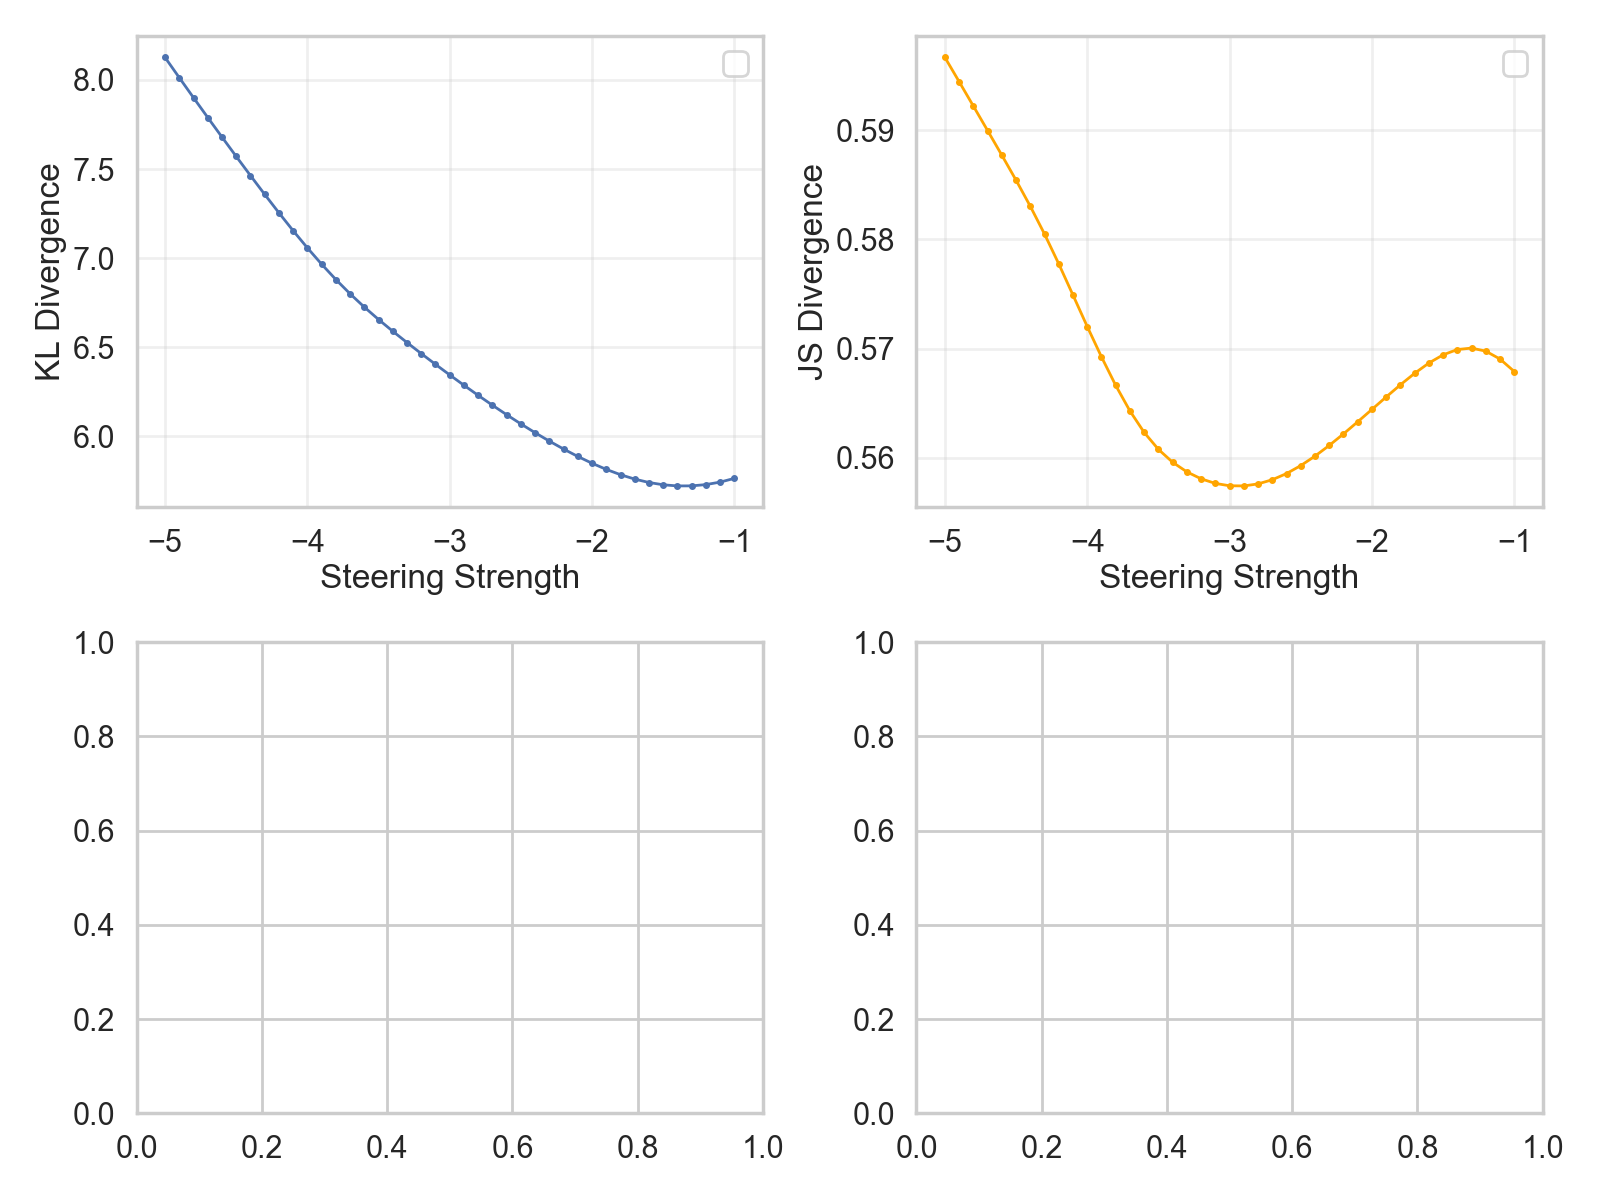

In [13]:
# Visualize grid search results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. KL Divergence vs Steering Value
ax1 = axes[0, 0]
ax1.plot(grid_results["steering_value"], grid_results["avg_kl_divergence"], "o-", linewidth=2, markersize=4)
best_kl_idx = grid_results["avg_kl_divergence"].idxmin()
ax1.set_xlabel("Steering Strength")
ax1.set_ylabel("KL Divergence")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. JS Divergence vs Steering Value
ax2 = axes[0, 1]
ax2.plot(
    grid_results["steering_value"], grid_results["avg_js_divergence"], "o-", linewidth=2, markersize=4, color="orange"
)
best_js_idx = grid_results["avg_js_divergence"].idxmin()
ax2.set_xlabel("Steering Strength")
ax2.set_ylabel("JS Divergence")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Run on entire dataset (or subset for testing)
# Use max_samples=100 for quick testing, None for full dataset
results_df = run_experiment_on_dataset(
    max_samples=None,
    steering_value=grid_results.loc[best_kl_idx, "steering_value"],
)

Running experiment on 2467 samples...


100%|██████████| 2467/2467 [09:47<00:00,  4.20it/s]


In [17]:
# Display summary statistics
print("\n" + "=" * 80)
print("AGGREGATED RESULTS ACROSS ALL SAMPLES")
print("=" * 80)

print("\n" + "-" * 80)
print("KL DIVERGENCE (lower = more similar)")
print("-" * 80)
print("\nRus (no steer) → Eng:")
print(f"  Mean: {results_df['kl_rus_no_to_eng'].mean():.4f}")
print(f"  Std:  {results_df['kl_rus_no_to_eng'].std():.4f}")
print(f"  Med:  {results_df['kl_rus_no_to_eng'].median():.4f}")

print("\nRus (WITH steer) → Eng:")
print(f"  Mean: {results_df['kl_rus_yes_to_eng'].mean():.4f}")
print(f"  Std:  {results_df['kl_rus_yes_to_eng'].std():.4f}")
print(f"  Med:  {results_df['kl_rus_yes_to_eng'].median():.4f}")

print(
    f"\n💡 Improvement: {((results_df['kl_rus_no_to_eng'].mean() - results_df['kl_rus_yes_to_eng'].mean()) / results_df['kl_rus_no_to_eng'].mean() * 100):.1f}% reduction in KL divergence"
)

print("\n" + "-" * 80)
print("JENSEN-SHANNON DIVERGENCE (lower = more similar, symmetric)")
print("-" * 80)
print("\nEng vs Rus (no steer):")
print(f"  Mean: {results_df['js_eng_vs_rus_no'].mean():.4f}")
print(f"  Std:  {results_df['js_eng_vs_rus_no'].std():.4f}")
print(f"  Med:  {results_df['js_eng_vs_rus_no'].median():.4f}")

print("\nEng vs Rus (WITH steer):")
print(f"  Mean: {results_df['js_eng_vs_rus_yes'].mean():.4f}")
print(f"  Std:  {results_df['js_eng_vs_rus_yes'].std():.4f}")
print(f"  Med:  {results_df['js_eng_vs_rus_yes'].median():.4f}")

print(
    f"\n💡 Improvement: {((results_df['js_eng_vs_rus_no'].mean() - results_df['js_eng_vs_rus_yes'].mean()) / results_df['js_eng_vs_rus_no'].mean() * 100):.1f}% reduction in JS divergence"
)

print("\n" + "-" * 80)
print("COSINE SIMILARITY (higher = more similar, range [-1, 1])")
print("-" * 80)
print("\nEng vs Rus (no steer):")
print(f"  Mean: {results_df['cos_eng_vs_rus_no'].mean():.4f}")
print(f"  Std:  {results_df['cos_eng_vs_rus_no'].std():.4f}")
print(f"  Med:  {results_df['cos_eng_vs_rus_no'].median():.4f}")

print("\nEng vs Rus (WITH steer):")
print(f"  Mean: {results_df['cos_eng_vs_rus_yes'].mean():.4f}")
print(f"  Std:  {results_df['cos_eng_vs_rus_yes'].std():.4f}")
print(f"  Med:  {results_df['cos_eng_vs_rus_yes'].median():.4f}")

print(
    f"\n💡 Improvement: {((results_df['cos_eng_vs_rus_yes'].mean() - results_df['cos_eng_vs_rus_no'].mean()) / (1 - results_df['cos_eng_vs_rus_no'].mean()) * 100):.1f}% increase toward perfect similarity"
)

print("\n" + "-" * 80)
print("TOP-50 TOKEN OVERLAP (higher = more similar, range [0, 1])")
print("-" * 80)
print("\nEng vs Rus (no steer):")
print(f"  Mean: {results_df['overlap_eng_vs_rus_no'].mean():.2%}")
print(f"  Std:  {results_df['overlap_eng_vs_rus_no'].std():.2%}")
print(f"  Med:  {results_df['overlap_eng_vs_rus_no'].median():.2%}")

print("\nEng vs Rus (WITH steer):")
print(f"  Mean: {results_df['overlap_eng_vs_rus_yes'].mean():.2%}")
print(f"  Std:  {results_df['overlap_eng_vs_rus_yes'].std():.2%}")
print(f"  Med:  {results_df['overlap_eng_vs_rus_yes'].median():.2%}")

print(
    f"\n💡 Improvement: {((results_df['overlap_eng_vs_rus_yes'].mean() - results_df['overlap_eng_vs_rus_no'].mean()) / (1 - results_df['overlap_eng_vs_rus_no'].mean()) * 100):.1f}% increase toward perfect overlap"
)


AGGREGATED RESULTS ACROSS ALL SAMPLES

--------------------------------------------------------------------------------
KL DIVERGENCE (lower = more similar)
--------------------------------------------------------------------------------

Rus (no steer) → Eng:
  Mean: 6.3686
  Std:  3.5237
  Med:  6.6034

Rus (WITH steer) → Eng:
  Mean: 5.8672
  Std:  3.2663
  Med:  4.9999

💡 Improvement: 7.9% reduction in KL divergence

--------------------------------------------------------------------------------
JENSEN-SHANNON DIVERGENCE (lower = more similar, symmetric)
--------------------------------------------------------------------------------

Eng vs Rus (no steer):
  Mean: 0.5523
  Std:  0.1842
  Med:  0.6372

Eng vs Rus (WITH steer):
  Mean: 0.5661
  Std:  0.1202
  Med:  0.5978

💡 Improvement: -2.5% reduction in JS divergence

--------------------------------------------------------------------------------
COSINE SIMILARITY (higher = more similar, range [-1, 1])
------------------------